### LSTM Model With Univariate Input and Vector Output


In [4]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# split a univariate dataset into train/test sets
def split_datasets(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:30], data[30:35]
	# restructure into windows of weekly data
# 	train = array(split(train, len(train)/7))
# 	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
#dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset = read_csv('shampoo-sales.csv', header=0, infer_datetime_format=True, index_col=['Month'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
#days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
#pyplot.plot(days, scores, marker='o', label='lstm')
#pyplot.show()

IndexError: tuple index out of range

### Encoder-Decoder LSTM Model With Multivariate Input

lstm: [471.405] 390.4, 396.3, 396.0, 441.7, 520.0, 550.6, 566.2


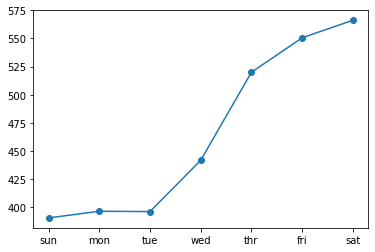

In [2]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

### multivariate output stacked lstm example

In [92]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence

# Read the data
data = read_csv('samples_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 2000
#dataset = raw_data[0:n_train,:]
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps = 30
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.1))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

# demonstrate iterative prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps,:]
print(f'Initial shape of x_input {x_inp.shape}')
# x_inp = array([[70,75,145], [80,85,165], [90,95,185]])
result = []
var_1, var_2, var_3, var_4, var_5 = list(), list(), list(), list(), list()
# num_repeat = 30
num_repeat = 30
for i in range(num_repeat):
  x_input = x_inp.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  # inv_yhat = scaler.inverse_transform(yhat)
  var_1.append(yhat[0][0])
  var_2.append(yhat[0][1])
  var_3.append(yhat[0][2])
  var_4.append(yhat[0][3])
  var_5.append(yhat[0][4])
  # p = np.append(x_inp[0],yhat[0][0])[1:]
  # q = np.append(x_inp[1],yhat[0][1])[1:]
  # r = np.append(x_inp[2],yhat[0][2])[1:]
  print(f'Value of yhat {yhat}')
  result = np.append(result,yhat[0])
  x_inp = np.append(x_inp,yhat[0])
  x_inp = x_inp.reshape(1,n_steps+1,5)
  x_inp = x_inp[:,1:,0:]

var = DataFrame(vstack((var_1,var_2,var_3,var_4,var_5))).T
inv_var = scaler.inverse_transform(var)
print("--------------AFTER THE INVERTED SCALING-------------------")
inv_var

Initial shape of x_input (30, 5)
Value of yhat [[ 0.00176799 -0.00356799  0.05131838  0.1508129   0.01267289]]
Value of yhat [[0.00838119 0.0116123  0.03542936 0.36865634 0.01393316]]
Value of yhat [[0.01785903 0.04081485 0.02368049 0.63909113 0.0217285 ]]
Value of yhat [[0.01860322 0.06592354 0.01871607 0.82650137 0.03057286]]
Value of yhat [[0.01377369 0.08495527 0.01960775 0.90523887 0.03658543]]
Value of yhat [[0.00981291 0.1034942  0.02062848 0.93978506 0.04097761]]
Value of yhat [[0.00676236 0.12139365 0.02191302 0.9554166  0.04392741]]
Value of yhat [[0.00460482 0.13842112 0.02426283 0.96220523 0.04541188]]
Value of yhat [[0.00334413 0.15442252 0.02729137 0.9646902  0.04563573]]
Value of yhat [[0.00248288 0.17016919 0.03066754 0.9652574  0.04468331]]
Value of yhat [[0.0018453  0.1858982  0.03424412 0.9649869  0.04276815]]
Value of yhat [[0.00169797 0.2015356  0.0377498  0.96456003 0.04038126]]
Value of yhat [[0.00173192 0.21668975 0.04118448 0.9644336  0.03813805]]
Value of yhat

array([[ 3.5006261e+00, -6.9647236e+00,  1.7586807e+02,  1.5081289e-01,
         1.2672894e-02],
       [ 1.6594751e+01,  2.2667202e+01,  1.2141641e+02,  3.6865634e-01,
         1.3933161e-02],
       [ 3.5360874e+01,  7.9670578e+01,  8.1153053e+01,  6.3909113e-01,
         2.1728501e-02],
       [ 3.6834377e+01,  1.2868275e+02,  6.4139961e+01,  8.2650137e-01,
         3.0572860e-02],
       [ 2.7271915e+01,  1.6583269e+02,  6.7195770e+01,  9.0523887e-01,
         3.6585428e-02],
       [ 1.9429554e+01,  2.0202068e+02,  7.0693810e+01,  9.3978506e-01,
         4.0977612e-02],
       [ 1.3389464e+01,  2.3696040e+02,  7.5095924e+01,  9.5541662e-01,
         4.3927409e-02],
       [ 9.1175365e+00,  2.7019803e+02,  8.3148720e+01,  9.6220523e-01,
         4.5411885e-02],
       [ 6.6213841e+00,  3.0143277e+02,  9.3527534e+01,  9.6469021e-01,
         4.5635730e-02],
       [ 4.9160948e+00,  3.3217026e+02,  1.0509767e+02,  9.6525741e-01,
         4.4683311e-02],
       [ 3.6536944e+00,  3.628

In [88]:
raw_data[2000:2020,0]

array([551, 535, 523, 511, 494, 481, 463, 451, 434, 420, 402, 388, 374,
       355, 340, 319, 304, 281, 264, 239], dtype=int64)

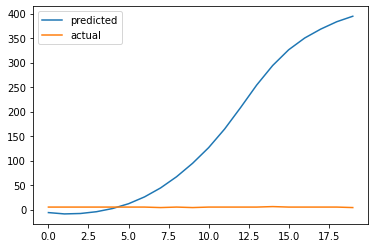

In [90]:
actual = raw_data[2000:2020,1]
pred = inv_var.T
plt.plot(pred[1], label="predicted")
plt.plot(actual, label="actual")
plt.legend()
plt.show()

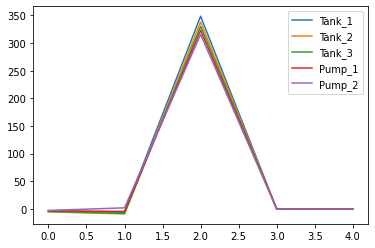

In [91]:
plt.plot(inv_var[0], label='Tank_1')
plt.plot(inv_var[1], label='Tank_2')
plt.plot(inv_var[2], label='Tank_3')
plt.plot(inv_var[3], label='Pump_1')
plt.plot(inv_var[4], label='Pump_2')
plt.legend()
plt.show()